# Chebychev design of an FIR filter given a desired $H(\omega)$

A derivative work by Judson Wilson, 5/27/2014.<br>
Adapted from the CVX example of the same name, by Almir Mutapcic, 2/2/2006.

Topic References:

* "Filter design" lecture notes (EE364) by S. Boyd

## Introduction

This program designs an FIR filter, given a desired frequency response $H_\mbox{des}(\omega)$.
The design is judged by the maximum absolute error (Chebychev norm).
This is a convex problem (after sampling it can be formulated as an SOCP),
which may be written in the form:
    \begin{array}{ll}
    \mbox{minimize}   &  \max |H(\omega) - H_\mbox{des}(\omega)| 
                             \quad \mbox{ for }  0 \le \omega \le \pi,
    \end{array}
where the variable $H$ is the frequency response function, corresponding to an impulse response $h$.

## Initialize problem data

In [1]:
import numpy as np
import cvxpy as cp

#********************************************************************
# Problem specs.
#********************************************************************
# Number of FIR coefficients (including the zeroth one).
n = 20

# Rule-of-thumb frequency discretization (Cheney's Approx. Theory book).
m = 15*n
w = np.linspace(0,np.pi,m)
#********************************************************************
# Construct the desired filter.
#********************************************************************
# Fractional delay.
D = 8.25                # Delay value.
Hdes = np.exp(-1j*D*w)  # Desired frequency response.

# Gaussian filter with linear phase. (Uncomment lines below for this design.)
#var = 0.05
#Hdes = 1/(np.sqrt(2*np.pi*var)) * np.exp(-np.square(w-np.pi/2)/(2*var))
#Hdes = np.multiply(Hdes, np.exp(-1j*n/2*w))


## Solve the minimax (Chebychev) design problem

In [2]:
# A is the matrix used to compute the frequency response
# from a vector of filter coefficients:
#     A[w,:] = [1 exp(-j*w) exp(-j*2*w) ... exp(-j*n*w)]
A = np.exp( -1j * np.kron(w.reshape(-1, 1), np.arange(n)))

# Presently CVXPY does not do complex-valued math, so the
# problem must be formatted into a real-valued representation.

# Split Hdes into a real part, and an imaginary part.
Hdes_r = np.real(Hdes)
Hdes_i = np.imag(Hdes)

# Split A into a real part, and an imaginary part.
A_R = np.real(A)
A_I = np.imag(A)

#
# Optimal Chebyshev filter formulation.
#

# h is the (real) FIR coefficient vector, which we are solving for.
h = cp.Variable(shape=n)
# The objective is:
#     minimize max(|A*h-Hdes|)
# but modified into an equivelent form:
#     minimize max( real(A*h-Hdes)^2 + imag(A*h-Hdes)^2 )
# such that all computation is done in real quantities only.
obj = cp.Minimize(
    cp.max(  cp.square(A_R * h - Hdes_r)     # Real part.
           + cp.square(A_I * h - Hdes_i) ) ) # Imaginary part.

# Solve problem.
prob = cp.Problem(obj)
prob.solve()

# Check if problem was successfully solved.
print('Problem status: {}'.format(prob.status))
if prob.status != cp.OPTIMAL:
    raise Exception('CVXPY Error')
print("final objective value: {}".format(obj.value))


Problem status: optimal
final objective value: 0.4999999999999996


## Result plots

Text(0.5, 1.0, 'FIR filter freq. response angle')

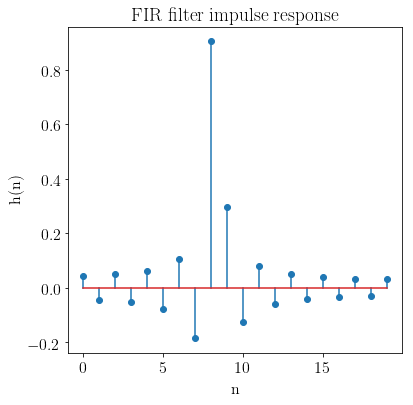

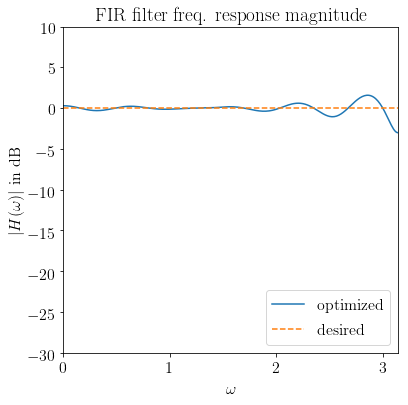

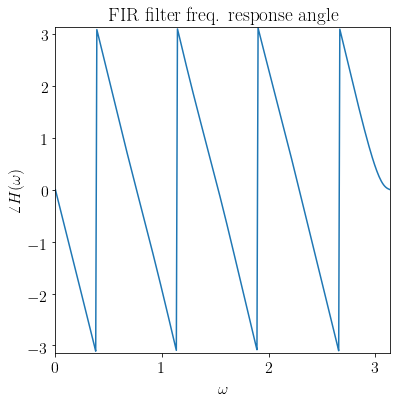

In [3]:
import matplotlib.pyplot as plt

# Show plot inline in ipython.
%matplotlib inline

# Plot properties.
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

# Plot the FIR impulse reponse.
plt.figure(figsize=(6, 6))
plt.stem(range(n), h.value)
plt.xlabel('n')
plt.ylabel('h(n)')
plt.title('FIR filter impulse response')

# Plot the frequency response.
H = np.exp(-1j * np.kron(w.reshape(-1, 1), np.arange(n))).dot(h.value)
plt.figure(figsize=(6, 6))
# Magnitude
plt.plot(w, 20 * np.log10(np.abs(H)),
         label='optimized')
plt.plot(w, 20 * np.log10(np.abs(Hdes)),'--',
         label='desired')
plt.xlabel(r'$\omega$')
plt.ylabel(r'$|H(\omega)|$ in dB')
plt.title('FIR filter freq. response magnitude')
plt.xlim(0, np.pi)
plt.ylim(-30, 10)
plt.legend(loc='lower right')
# Phase
plt.figure(figsize=(6, 6))
plt.plot(w, np.angle(H))
plt.xlim(0, np.pi)
plt.ylim(-np.pi, np.pi)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\angle H(\omega)$')
plt.title('FIR filter freq. response angle')